In [1]:
import cv2
import os
from collections import Counter
from collections import defaultdict
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import math
import pandas as pd
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN #Added
from scipy.spatial import distance as dist
from collections import OrderedDict
from PIL import Image

from csv import writer,reader

In [2]:
class CentroidTracker:
    def __init__(self, maxDisappeared=150, centroid_matching_threshold = 50, 
                  face_matching_threshold=100.0, required_size=(160, 160)):
        # initialize the next unique object ID along with two ordered
        # dictionaries used to keep track of mapping a given object
        # ID to its centroid and number of consecutive frames it has
        # been marked as "disappeared", respectively
        self.nextObjectID = 0
        self.objects = OrderedDict()
        self.objectEmbedding = OrderedDict()
        self.objectFace = OrderedDict()
        self.data = OrderedDict()
        self.disappeared = OrderedDict()

        # store the number of maximum consecutive frames a given
        # object is allowed to be marked as "disappeared" until we
        # need to deregister the object from tracking
        self.maxDisappeared = maxDisappeared
        self.centroid_matching_threshold = centroid_matching_threshold


        model_path = r'models\FaceNet\model-20211123T073420Z-001\model\facenet_keras.h5'
        self.facenet_model = load_model(model_path)
        self.object = OrderedDict()
        self.face_matching_threshold = face_matching_threshold
        self.required_size = required_size

    # get the face from the image by the rectangle
    def extract_face(self, image, rectangle):
        x1, y1, x2, y2 = rectangle
        x1, y1, x2, y2 = abs(x1), abs(y1), abs(x2), abs(y2)
        face = image[y1:y2, x1:x2]
        
        # resize pixels to the facenet model size
        face = Image.fromarray(face)
        face = face.resize(self.required_size)
        face_array = np.asarray(face)
        return face_array

    # get the face embedding for one face
    def get_embedding(self, face_pixels):
        # scale pixel values
        face_pixels = face_pixels.astype('float32')
        # standardize pixel values across channels (global)
        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / std
        # transform face into one sample
        samples = np.expand_dims(face_pixels, axis=0)
        # make prediction to get embedding
        yhat = self.facenet_model.predict(samples)
        return yhat[0]
    
    # update the embedding of the person based on the current and matched embedding
    def update_embedding(self, objectID, embed1, embed2):
        # averaging over the two embeddings
        self.objectEmbedding[objectID] = (embed1 + embed2)/2
        
    # update the image with the latest face image
    def update_image(self, objectID, image, rectangle):
        self.objectFace[objectID] = self.extract_face(image, rectangle)

    def register(self, centroid, face_pixels, face_embedding):
        # when registering an object we use the next available object
        # ID to store the centroid
        self.objects[self.nextObjectID] = centroid
        self.disappeared[self.nextObjectID] = 0

        self.objectEmbedding[self.nextObjectID] = face_embedding
        self.objectFace[self.nextObjectID] = face_pixels
        self.data[self.nextObjectID] = dict()
        
        self.nextObjectID += 1
        return self.nextObjectID - 1
        
    def deregister(self, objectID):
        # to deregister an object ID we delete the object ID from
        # both of our respective dictionaries
        del self.objects[objectID]
        del self.disappeared[objectID]
    
    def update_id_data(self, objectID, frameNum, emotion_id, faceOrientation, centroid):
        emotion_array = np.zeros(7)
        emotion_array[int(emotion_id)] = 1
        self.data[objectID][frameNum] = (*list(emotion_array), faceOrientation, centroid)
    
    def update_id_data_version2(self, objectID, frameNum, engagement_level, e_score, o_score, c_score):
        self.data[objectID][frameNum] = [engagement_level, e_score, o_score, c_score]

    def update(self, image, rects):
        # check to see if the list of input bounding box rectangles
        # is empty
        
        if len(rects) == 0:
            # loop over any existing tracked objects and mark them
            # as disappeared
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1

                # if we have reached a maximum number of consecutive
                # frames where a given object has been marked as
                # missing, deregister it
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)

            # return early as there are no centroids or tracking info
            # to update
            return self.objects, None
        
        # matching of id with rectangles
        ret_Matching = [None] * len(rects)
        
        
        # initialize an array of input centroids for the current frame
        inputCentroids = np.zeros((len(rects), 2), dtype="int")

        # loop over the bounding box rectangles
        for (i, (startX, startY, endX, endY)) in enumerate(rects):
            # use the bounding box coordinates to derive the centroid
            #startX, startY, endX, endY = startX/image.shape[0], startY/image.shape[1], endX/image.shape[0], endY/image.shape[1]
            cX = int((startX + endX) / 2.0)
            cY = int((startY + endY) / 2.0)
            inputCentroids[i] = (cX, cY)

        unmatched_dets = None
        matched_ids = set()

        # if we are currently not tracking any objects take the input
        # centroids and register each of them
        if len(self.objectEmbedding) == 0:
            for i, rect in enumerate(rects):
                face_pixels = self.extract_face(image, rect)
                face_embedding = self.get_embedding(face_pixels)
                ret_Matching[i] = self.register(inputCentroids[i], face_pixels, face_embedding)
                

        elif len(self.objects) == 0:
            unmatched_dets = set(range(0, len(rects)))

        # otherwise, are are currently tracking objects so we need to
        # try to match the input centroids to existing object
        # centroids
        else:
            # grab the set of object IDs and corresponding centroids
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())

            # compute the distance between each pair of object
            # centroids and input centroids, respectively -- our
            # goal will be to match an input centroid to an existing
            # object centroid
            D = dist.cdist(np.array(objectCentroids), inputCentroids)

            # in order to perform this matching we must (1) find the
            # smallest value in each row and then (2) sort the row
            # indexes based on their minimum values so that the row
            # with the smallest value as at the *front* of the index
            # list
            rows = D.min(axis=1).argsort()

            # next, we perform a similar process on the columns by
            # finding the smallest value in each column and then
            # sorting using the previously computed row index list
            cols = D.argmin(axis=1)[rows]

            # in order to determine if we need to update, register,
            # or deregister an object we need to keep track of which
            # of the rows and column indexes we have already examined
            usedRows = set()
            usedCols = set()

            # loop over the combination of the (row, column) index
            # tuples
            for (row, col) in zip(rows, cols):
                # if we have already examined either the row or
                # column value before, ignore it
                # val
                if row in usedRows or col in usedCols:
                    continue

                # otherwise, grab the object ID for the current row,
                # set its new centroid, and reset the disappeared
                # counter
                # Also checking if the distance is under the matching_threshold or not
                if D[row, col] > self.centroid_matching_threshold:
                    break

                objectID = objectIDs[row]
                self.objects[objectID] = inputCentroids[col]
                self.disappeared[objectID] = 0
                #print("Inside centroid matching: ", row, col, objectID)

                # indicate that we have examined each of the row and
                # column indexes, respectively
                usedRows.add(row)
                usedCols.add(col)
                ret_Matching[col] = objectID
                matched_ids.add(objectID)

            # compute both the row and column index we have NOT yet
            # examined
            unmatched_dets = set(range(0, D.shape[1])).difference(usedCols)

        if unmatched_dets:
           
            
            unmatched_dets = list(unmatched_dets)
            detection_faces, detection_embeddings = [], []
            saved_ids = []
            saved_embeddings = []

            for ids, embedding in self.objectEmbedding.items():
                saved_ids.append(ids)
                saved_embeddings.append(embedding)

            for det in unmatched_dets:
                x1, y1, x2, y2 = rects[det]
                x1, y1, x2, y2 = abs(x1), abs(y1), abs(x2), abs(y2)
                detection_faces.append(self.extract_face(image, rects[det]))
                detection_embeddings.append(self.get_embedding(detection_faces[-1]))

            D = dist.cdist(np.asarray(detection_embeddings), np.asarray(saved_embeddings))

            rows = D.min(axis=1).argsort()
            cols = D.argmin(axis=1)[rows]

            usedRows = set()

            # loop over the combination of the (row, column) index
            # tuples
            for (row, col) in zip(rows, cols):
                # if we have already examined either the row or
                # column value before, ignore it
                # val
                objectID = saved_ids[col]

                if row in usedRows or objectID in matched_ids:
                    continue

                if D[row, col] > self.face_matching_threshold:
                    break

                self.objects[objectID] = inputCentroids[unmatched_dets[row]]
                self.disappeared[objectID] = 0
                
                # update the embedding
                self.update_embedding(objectID, detection_embeddings[row], saved_embeddings[col])
                # update the image
                self.update_image(objectID, image, rects[unmatched_dets[row]])
                
                ret_Matching[unmatched_dets[row]] = objectID
                usedRows.add(row)
                matched_ids.add(objectID)

            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            #print("Inside face recognition: ",unmatched_dets, unusedRows)
            
            for row in unusedRows:
                centroid = inputCentroids[unmatched_dets[row]]
                ret_Matching[unmatched_dets[row]] = self.register(centroid, detection_faces[row], detection_embeddings[row])

        # we need to check and see if some of these objects have
        # potentially disappeared
        deregister_id = []
        for objectID, value in self.objects.items():
            # index and increment the disappeared counter
            if objectID in matched_ids:
                continue
                
            self.disappeared[objectID] += 1

            # check to see if the number of consecutive
            # frames the object has been marked "disappeared"
            # for warrants deregistering the object
            if self.disappeared[objectID] > self.maxDisappeared:
                deregister_id.append(objectID)
        
        for objectID in deregister_id:
            self.deregister(objectID)
        
        # return the set of trackable objects
        return self.objects, ret_Matching
    
    
    def save_data(self, output_base_path, frame_num_li):
        image_path = os.path.join(output_base_path, 'image')
        data_path = os.path.join(output_base_path, 'data')

        os.mkdir(image_path)
        os.mkdir(data_path)

        for objectID, data in self.data.items():
            image = self.objectFace[objectID]
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            for frame_num in frame_num_li:
                if frame_num not in data:
                    data[frame_num] = (None, None, None)
            
            df = pd.DataFrame.from_dict(data, orient='index')
            df = df.sort_index()
            df.index.name = 'Frame'
            df.columns = ['Boredome','Confused','Engaged','Frustrated','Happy','Sleepy','Yawning','Head Orientation', 'Centroid']
            
            person_image_path = os.path.join(image_path, 'person_'+str(objectID)+'.jpg')
            file_path = os.path.join(data_path, 'person_'+str(objectID)+'.csv')
            
            cv2.imwrite(person_image_path, image)
            df.to_csv(file_path, sep=',',index=True, header=True)

        print("Images and Data written at {}".format(output_base_path))
        
    def save_data_version2(self, output_base_path, frame_num_li, count_VH_engaged_li,count_H_engaged_li,count_M_engaged_li,count_L_engaged_li,count_VL_engaged_li,MGEL):
        
        group_engagement_file_path = os.path.join(output_base_path, 'group_engagement.csv')
        df = pd.DataFrame(list(zip(count_VH_engaged_li,count_H_engaged_li,count_M_engaged_li,count_L_engaged_li,count_VL_engaged_li,MGEL)))
        df.index.name = 'Frame'
        df.columns = ['VHEL','HEL','MEL','LEL', 'VLEL','MGEL'] #VHEL-> Very high engagement level, #HEL -> High engagement level
                #MEL - > Moderate EL, LEL -> Low EL, VLEL-> Very low EL, MGEL-> Maximum Group Engagement Level
        df.to_csv(group_engagement_file_path, sep=',',index=True, header=True)
        
        
        image_path = os.path.join(output_base_path, 'image')
        data_path = os.path.join(output_base_path, 'data')

        os.mkdir(image_path)
        os.mkdir(data_path)
        
        for objectID, data in self.data.items():
            image = self.objectFace[objectID]
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            for frame_num in frame_num_li:
                if frame_num not in data:
                    data[frame_num] = [None, None, None]
            
            df = pd.DataFrame.from_dict(data, orient='index')
            df = df.sort_index()
            df.index.name = 'Frame'
            df.columns = ['Engagement Level', 'Emotion Score', 'Orientation Score', 'Head Movement Score']
            
            person_image_path = os.path.join(image_path, 'person_'+str(objectID)+'.jpg')
            file_path = os.path.join(data_path, 'person_'+str(objectID)+'.csv')
            
            cv2.imwrite(person_image_path, image)
            df.to_csv(file_path, sep=',',index=True, header=True)

        print("Images and Data written at {}".format(output_base_path))


In [3]:
def face_orientation(frame, landmarks):
    size = frame.shape #(height, width, color_channel)

    image_points = np.array([
                            (landmarks[2][0], landmarks[2][1]),     # Nose tip
                            (landmarks[5][0], landmarks[5][1]),     # Chin
                            (landmarks[0][0], landmarks[0][1]),     # Left eye left corner
                            (landmarks[1][0], landmarks[1][1]),     # Right eye right corne
                            (landmarks[3][0], landmarks[3][1]),     # Left Mouth corner
                            (landmarks[4][0], landmarks[4][1])      # Right mouth corner
                        ], dtype="double")

    

                        
    model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-165.0, 170.0, -135.0),     # Left eye left corner
                            (165.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner                         
                        ])

    # Camera internals
    center = (size[1]/2, size[0]/2)
    focal_length = center[0] / np.tan(60/2 * np.pi / 180)
    camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )

    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE) #flags=cv2.CV2_ITERATIVE)

    
    axis = np.float32([[500,0,0],[0,500,0],[0,0,500]])
                          
    imgpts, jac = cv2.projectPoints(axis, rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    modelpts, jac2 = cv2.projectPoints(model_points, rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    rvec_matrix = cv2.Rodrigues(rotation_vector)[0]

    proj_matrix = np.hstack((rvec_matrix, translation_vector))
    eulerAngles = cv2.decomposeProjectionMatrix(proj_matrix)[6] 

    
    pitch, yaw, roll = [math.radians(_) for _ in eulerAngles]


    pitch = math.degrees(math.asin(math.sin(pitch)))
    roll = -math.degrees(math.asin(math.sin(roll)))
    yaw = math.degrees(math.asin(math.sin(yaw)))

    return imgpts, modelpts, (str(int(pitch)), str(int(roll)), str(int(yaw))), (landmarks[2][0], landmarks[2][1])

In [4]:
def chin_point(ML,MR,nose): #ML:-mouth left, MR:- mouth right , MC= mouth center 
    MC=[(ML[0]+MR[0])//2,(ML[1]+MR[1])//2]
    diff=[MC[0]-nose[0],MC[1]-nose[1]]
    Cpoint=(MC[0],MC[1]+diff[1])
    return Cpoint

In [5]:
import numpy as np


def orient_score(orient):
    #positive_score, zero_score = ["Frontal_Face"], ["Head_down", "Left_skew", "Right_skew"]
    positive_score, zero_score = ["Frontal"], ["NaN","Down","L_Skew", "R_Skew"]
    if orient in positive_score:
        return 1
    else:
        return 0
    
def emotion_score(emotion):
    positive_score, zero_score = ['Happy', 'Focused'], ['Boredome', 'Confused', 'Frustrated', 'Sleepy', 'Yawning']
    if emotion in positive_score:
        return 1
    else:
        return 0

def centroid_processing(cur, prev=None):
    if prev is None or cur is None:
        return 0
    return np.linalg.norm(np.array(cur) - np.array(prev))
    
def centroid_score(centroid_list, max_head_dist_threshold=10):
    #print("Centroid List\n",centroid_list)
    dist_sum = 0
    for i in range(1, len(centroid_list)):
        dist_sum += centroid_processing(centroid_list[i], centroid_list[i-1])
    
    #print("Distance: ",dist_sum)
    
    if dist_sum < max_head_dist_threshold:
        return 1
    else:
        return 0

def process_scores(e_score, o_score, c_score):
    #fusedscore=(0.4*e_score)+(0.35*o_score)+(0.25*c_score) #assign baised weight for respective modalities
    fusedscore=(0.532*e_score)+(0.266*o_score)+(0.192*c_score) #assign baised weight for respective modalities
    #if e_score + o_score + c_score >= 2:
    if fusedscore >=0.900:
        return 4 # very high engagement level
    elif fusedscore >= 0.798 and fusedscore < 0.900:
        return 3 # high engagement level 
    elif fusedscore >= 0.652 and fusedscore < 0.798:
        return 2 # moderate engagement level
    elif fusedscore >= 0.400 and fusedscore < 0.652:
        return 1 # low engagement
    return 0 # very low engagement level
    
def process_data(person_data):
    columns = list(zip(*person_data))
    emotion = Counter(columns[0]).most_common(1)[0][0]
    orient = Counter(columns[1]).most_common(1)[0][0]
    e_score = emotion_score(emotion)
    o_score = orient_score(orient)
    c_score = centroid_score(columns[2])
    return process_scores(e_score, o_score, c_score), emotion, orient, e_score, o_score, c_score

def append_data(objectid, person_track_data, emotion, orient, centroid):
    if objectid in person_track_data:
        person_track_data[objectid].append([emotion, orient, centroid])
    else:
        person_track_data[objectid] = [[emotion, orient, centroid]]


def EuclideanDistance(point1,point2):
    # finding sum of squares 
    sum_sq = np.sum(np.square(point1 - point2))
    # Doing squareroot and 
    # printing Euclidean distance 
    return np.sqrt(sum_sq)

    
def alignment_procedure(img, left_eye, right_eye):
#this function aligns given face in img based on left and right eye coordinates
 
    left_eye_x, left_eye_y = left_eye
    right_eye_x, right_eye_y = right_eye

    #-----------------------
    #find rotation direction

    if left_eye_y > right_eye_y:
        point_3rd = (right_eye_x, left_eye_y)
        direction = -1 #rotate same direction to clock
    else:
        point_3rd = (left_eye_x, right_eye_y)
        direction = 1 #rotate inverse direction of clock

    #-----------------------
    #find length of triangle edges

    a = EuclideanDistance(np.array(left_eye), np.array(point_3rd))
    b = EuclideanDistance(np.array(right_eye), np.array(point_3rd))
    c = EuclideanDistance(np.array(right_eye), np.array(left_eye))

    #-----------------------

    #apply cosine rule

    if b != 0 and c != 0: #this multiplication causes division by zero in cos_a calculation

        cos_a = (b*b + c*c - a*a)/(2*b*c)
        angle = np.arccos(cos_a) #angle in radian
        angle = (angle * 180) / math.pi #radian to degree

        #-----------------------
        #rotate base image

        if direction == -1:
            angle = 90 - angle

        img = Image.fromarray(img)
        img = np.array(img.rotate(direction * angle))

    #-----------------------

    return img #return img anyway

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def engagement_plot_hist(y, plot_width=480, plot_height=200, dpi=400):
    x = (0, 1, 2, 3, 4)
    fig = plt.figure(dpi=dpi)
    opacity = 1.0
    bar_width = 0.5

    plt.xlabel('Engagement Level[Very high to very low]')
    plt.ylabel('Count')

    plt.xticks(x, ('4', '3', '2', '1', '0'), rotation=0)
    
    plt.gcf().set_size_inches(4, 3)
    bar1 = plt.bar(x, y, bar_width, align='center', alpha=opacity, color=[(0.0,1.0,0.0,1.0),(1.0,1.0,0.0,1.0),(1.0,0.0,0.0,1.0),(1.0,0.0,1.0,1.0),(0.0,0.0,1.0,1.0)])
                                                                   #color=[green, cyan, orange, pink, red]                     
    # Add counts above the bars
    for rect in bar1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

    plt.tight_layout()    
    fig.canvas.draw()

    # Now we can save it to a numpy array.
    data2 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data2 = data2.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()
    
    return data2




def engagement_plot_line(y, z, plot_width=480, plot_height=200, dpi=400):
    x = list(range(len(y)))

    fig = plt.figure()
    
    plt.xlabel('Time')
    plt.ylabel('Student Count')
    
    #plt.gcf().canvas.draw()
    plt.gcf().set_size_inches(10, 4)
    #plt.plot(x,y, color=(0.0,1.0,0.0,1.0), label='VHigh_Engaged [4]')
    plt.plot(x,z, color=(0.0,0.0,1.0,1.0), label='VLow_Engaged [0]',linewidth='2')

    plt.legend()
    plt.tight_layout() 
    fig.canvas.draw()

    # Now we can save it to a numpy array.
    data2 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data2 = data2.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    #data2 = cv2.resize(data2, (plot_width, plot_height))
    #cv2.imwrite('test2.png',data2)
    plt.close()
    
    return data2

def engagement_plot(V,W,X,Y,Z, plot_width=480, plot_height=200, dpi=200):
    
    plot_hist = engagement_plot_hist([V[-1],W[-1],X[-1], Y[-1],Z[-1]], plot_width, plot_height, dpi)
    plot_line = engagement_plot_line(V,Z, plot_width, plot_height, dpi)
    plot = np.ones((plot_hist.shape[0] + plot_line.shape[0], max(plot_line.shape[1], plot_hist.shape[1]), 3), dtype=np.uint8) * 255
    
    plot[:plot_hist.shape[0], :plot_hist.shape[1], :] = plot_hist
    plot[plot_hist.shape[0]:plot_hist.shape[0] + plot_line.shape[0], :plot_line.shape[1], :] = plot_line
    
    return plot



In [7]:
base_path = './runs'
aggregation_threshold = 10

if os.listdir(base_path):
    run_num = max((int(runs[3:]) for runs in os.listdir(base_path))) + 1
else:
    run_num = 1

output_base_path = os.path.join(base_path, 'run'+str(run_num))
os.mkdir(output_base_path)
video_path = os.path.join(output_base_path, 'result.avi')


# initialize our centroid tracker and frame dimensions
ct = CentroidTracker()
(H, W) = (None, None)

# Initialize face detector model MTCNN
face_detector = MTCNN()

#Load model for Emotion Detection
FER_model = load_model(r"models\MobileNetV2_WFT-Exp6_final.h5")


# initialize the video stream and allow the camera sensor to warmup
print("[INFO] starting video stream.")

cap=cv2.VideoCapture(r"data\Test_S1.mp4")
#cap=cv2.VideoCapture(r"G:\Master Classroom Dataset\LH2_Behaviour Dataset_29.12.2021\Unfocused\DSC_0013.MOV")
    
out_width, out_height = 1280, 600 #600
out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), fps=5, frameSize=(out_width, out_height))


# Get frame rate of video stream
seconds = 0.2 # two frames per second get processed 
fps=cap.get(cv2.CAP_PROP_FPS) # Gets the frames per second
print("Frame rate",fps)
multiplier = fps * seconds

c=0

#count total number of frames
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total no. of frames in the Recorded Video :",length)

#for putting the data into csv file
frame_num_li = []
count_VH_engaged_li = [0]
count_H_engaged_li = [0]
count_M_engaged_li = [0]
count_L_engaged_li = [0]
count_VL_engaged_li = [0]
Group_engage_li = [0]


#for thresholding purpose with aggregation_threshold
num_processed_frames = 0 # used for internal calculation
num_classified_frames = 0 # used for internal calculation
total_processed_frames = 0 # for the number of frames processed in total
person_track_data = {}

#for time calculations
start_time = time.time()
face_detection_time = 0.0
emotion_prediction_time = 0.0
tracking_time = 0.0
feature_extraction_time = 0.0

while(cap.isOpened()):
    
    frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
    ref, frame = cap.read()
    
    if frame is None:
        break

    if frameId % multiplier == 0:
      
        #print("Frame Number:",frameId)
        frame = cv2.resize(frame, (1280, 720), interpolation = cv2.INTER_LINEAR)
        #frame = imutils.resize(img_frame, width=1280)
        img_frame=frame.copy()
        #print frame number on frame
        frame_ID="FrameNo:"+str(frameId)

        #frame_count="Frame_count"+str(FC)
        cv2.putText(frame, frame_ID, ((10), (50)), cv2.FONT_HERSHEY_DUPLEX, 1, (0,255,0), 1)

        #cv2.putText(temp_img, frame_count, ((10), (60)), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 2,cv2.LINE_AA)

        #convert image from BGR2RGB which MTCNN works well
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
       
        if W is None or H is None:
            (H, W) = frame.shape[:2]
     
        # construct a blob from the frame, pass it through the network,
        # obtain our output predictions, and initialize the list of
        # bounding box rectangles
        cur_time = time.time() # time lines
        faces = face_detector.detect_faces(frame)
        face_detection_time += time.time() - cur_time # time lines
        rects = []
        box_=[]
        landmarks_=[]
    
        num_processed_frames += 1
        total_processed_frames += 1
        
        # loop over the detections
        for face in faces:
            score = face["confidence"]
            if score > 0.98:  # face confidence score to avoid false positive faces
                # get face coordinates
                x,y,w,h= face['box']
                box=[x,y,w,h]
            
                #Keypoints extraction
                keypoints = face['keypoints']
                A=keypoints['left_eye']
                B=keypoints['right_eye']
                C=keypoints['nose']
                D=keypoints['mouth_left']
                E=keypoints['mouth_right']
                CP=chin_point(D,E,C)
            
                #get the facial land marks
                landmarks=[A,B,C,D,E,CP]

                #appen all faces info into list
                box_.append(box)
                landmarks_.append(landmarks)
                rects.append([x,y,x+w,y+h])
                             
            
            
        # update our centroid tracker using the computed set of bounding
        # box rectangles
        cur_time = time.time() # time lines
        objects, matchings = ct.update(img_rgb, rects)
        tracking_time += time.time() - cur_time # time lines

        for i in range(0, len(rects)):
            objectID = matchings[i]

            # filter out weak detections by ensuring the predicted
            # probability is greater than a minimum threshold

            #face rects
            face_rects= int(box_[i][0]),int(box_[i][1]),int(box_[i][2]),int(box_[i][3])
            #actual rectangle coordinates for face crop to pass to FEM model
            (X1, Y1, wd, he)=face_rects
            X2, Y2 = X1 + wd, Y1 + he

            #facial landmarks
            faces_keys=(landmarks_[i][0],landmarks_[i][1],landmarks_[i][2],landmarks_[i][3],landmarks_[i][4],landmarks_[i][5])
            #faces_keys=np.asarray(faces_keys) 

            box1 = int(box_[i][0]),int(box_[i][1]),int(box_[i][0]+box_[i][2]),int(box_[i][1]+box_[i][3])
            box1=np.asarray(box1)

            # use the bounding box coordinates to derive the centroid
            centroid = (int((X1 + X2) / 2.0), int((Y1 + Y2) / 2.0))


            imgpts, modelpts, rotate_degree, nose = face_orientation(frame, faces_keys)
            cv2.line(frame, nose, tuple(imgpts[1].ravel()), (0,255,0), 2) #GREEN
            cv2.line(frame, nose, tuple(imgpts[0].ravel()), (255,0,0), 2) #BLUE
            cv2.line(frame, nose, tuple(imgpts[2].ravel()), (0,0,255), 3) #RED


            pitch=rotate_degree[0]
            roll=rotate_degree[1]
            yaw=rotate_degree[2]

            orient='NaN'
            #pitch(+ve->headup and -ve->headdown)
            #yaw(+ve->rightturn and -ve-> leftturn)
            #roll(+ve->leftslant and -ve-> rightslant)


            '''if int(roll) in range(-50,50) and int(pitch) in range(-20,20) and int(yaw) in range(-40,40):
                orient="Frontal"
            elif int(pitch) < -15:
                orient="Head_Down"    
            elif int(yaw)<-40: 
                orient="L_Skew"
            elif int(yaw) >=40:
                orient="R_Skew"'''

            if int(roll) in range(-45,45) and int(pitch)in range(-15,18) and int(yaw) in range(-35,40):
                orient="Frontal"
            elif int(pitch) < -15:
                orient="Down"    
            elif int(yaw)<-35: 
                orient="L_Skew"
            elif int(yaw) >=40:
                orient="R_Skew"

           
            left_eye,right_eye=landmarks_[i][0],landmarks_[i][1]    

            roi_face = img_frame[Y1:Y1+he , X1:X1+wd]

            aligned_roi_face=alignment_procedure(roi_face,left_eye,right_eye)

            roi=cv2.resize(aligned_roi_face,(224,224),interpolation=cv2.INTER_LINEAR)
            roi = roi/255.
            roi=roi.reshape(1,224,224,3)

            #predictions = int(np.argmax(FER_model.predict(roi,1,verbose=0),axis=1))
            cur_time = time.time() # time lines
            predictions = FER_model.predict(roi)
            emotion_prediction_time += time.time() - cur_time # time lines

            #print(predictions)  
            # find max indexed array
            max_index = np.argmax(predictions)
            emotions = ('Boredome', 'Confused','Focused','Frustrated','Happy','Sleepy','Yawning')
            # emotion_Dict = {0: 'angry', 1: 'disgut', 3: 'fear', 4: 'happy', 5:'sad', 6:'surprise', 7: 'neutral'}
            emotions_ID = ['0', '1', '2', '3', '4', '5','6']
            predicted_emotion = emotions[max_index]
            #predicted_emotion_id = emotions_ID[max_index]


            cv2.rectangle(frame, (X1-20, Y1 - 20), (X2+20, Y1), (0,0,0), cv2.FILLED)
            cv2.putText(frame,str(predicted_emotion), (X1-18, Y1-3),cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255,255,255), 1)
            cv2.rectangle(frame, (X1-20,Y2+20),(X2+20,Y2), (0,0,0), cv2.FILLED)
            cv2.putText(frame,str(orient), (X1-18, Y2+17), cv2.FONT_HERSHEY_COMPLEX_SMALL,1, (255,255,255), 1)

           
            # appending the data to person_track_data
            append_data(objectID, person_track_data, predicted_emotion, orient, centroid)


        count_VH_engaged = 0
        count_H_engaged = 0
        count_M_engaged = 0
        count_L_engaged = 0
        count_VL_engaged = 0
        
        
        for i in range(0, len(rects)):
            objectID = matchings[i]
            #emotion,orient,_=
            face_rects= int(box_[i][0]),int(box_[i][1]),int(box_[i][2]),int(box_[i][3])
            #actual rectangle coordinates for face crop to pass to FEM model
            (X1, Y1, wd, he)=face_rects #(top, right, bottom, left)
            X2, Y2 = X1 + wd, Y1 + he
            cv2.rectangle(frame,(X1, Y1),(X2,Y2),(255,255,255),2)
            # Draw a label with a name below the face
            #left,top,right,bottom=X1,Y1,X2,Y2
            #cv2.rectangle(frame, (X1+2, Y1 + 20), (X2-2, Y1), (33,67,101), cv2.FILLED)
            cv2.rectangle(frame, (X2+2, Y1 + 20), (X2+55, Y1), (33,67,101), cv2.FILLED)
            font = cv2.FONT_HERSHEY_COMPLEX_SMALL
            cv2.putText(frame,"ID:"+str(objectID) , (X2+5,Y1+17), font, 1.0, (0, 255, 255), 1)



        if num_processed_frames == aggregation_threshold:
            num_classified_frames += 1
            frame_num_li.append(num_classified_frames)
            person_engagement = {}  

            #
            #processing the data
            #
            for objectId, person_data in person_track_data.items():

                engagement_level, emotion, orient, e_score, o_score, c_score = process_data(person_data)
                #print(objectId, emotion, orient, engagement_level)
                person_engagement[objectId] = (engagement_level, emotion, orient)

                ct.update_id_data_version2(objectId, num_classified_frames, engagement_level, e_score, o_score, c_score)
                if engagement_level==4:
                    count_VH_engaged += 1
                elif engagement_level==3:
                    count_H_engaged += 1
                elif engagement_level==2:
                    count_M_engaged += 1
                elif engagement_level==1:
                    count_L_engaged += 1
                else:
                    count_VL_engaged += 1
                    
            if count_VH_engaged == max(count_VH_engaged,count_H_engaged,count_M_engaged,count_L_engaged,count_VL_engaged):
                MGEL=4
            elif count_H_engaged == max(count_VH_engaged,count_H_engaged,count_M_engaged,count_L_engaged,count_VL_engaged):
                MGEL=3
            elif count_M_engaged == max(count_VH_engaged,count_H_engaged,count_M_engaged,count_L_engaged,count_VL_engaged):
                MGEL=2
            elif count_L_engaged == max(count_VH_engaged,count_H_engaged,count_M_engaged,count_L_engaged,count_VL_engaged):       
                MGEL=1
            else:
                MGEL=0
            #print(count_engaged, count_non_engaged)
            #count_engaged_li.append(count_engaged)
            #count_non_engaged_li.append(count_non_engaged)
            
            count_VH_engaged_li.append(count_VH_engaged)
            count_H_engaged_li.append(count_H_engaged) 
            count_M_engaged_li.append(count_M_engaged) 
            count_L_engaged_li.append(count_L_engaged) 
            count_VL_engaged_li.append(count_VL_engaged)
            Group_engage_li.append(MGEL)
            num_processed_frames = 0
            person_track_data = {}


            #
            # for display on the frame
            #
            for i in range(0, len(rects)):
                objectID = matchings[i]      
                face_rects= int(box_[i][0]),int(box_[i][1]),int(box_[i][2]),int(box_[i][3])
                #actual rectangle coordinates for face crop to pass to FEM model
                (X1, Y1, wd, he)=face_rects
                X2, Y2 = X1 + wd, Y1 + he

                engagement_level, emotion, orient = person_engagement.get(objectID, (-1, -1, -1))
                #print(objectID, engagement_level, emotion, orient)

                if engagement_level == 4:
                    cv2.rectangle(frame,(X1,Y1),(X2,Y2),(0,255,0),2)
                    cv2.rectangle(frame, (X1-20, Y1 - 20), (X2+25, Y1), (0,0,0), cv2.FILLED)
                    cv2.putText(frame,str('VH_Engaged'), (X1-18, Y1-3),cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0), 1)
                elif engagement_level == 3:
                    cv2.rectangle(frame,(X1,Y1),(X2,Y2),(255,255,0),2)
                    cv2.rectangle(frame, (X1-20, Y1 - 20), (X2+25, Y1), (0,0,0), cv2.FILLED)
                    cv2.putText(frame,str('H_Engaged'), (X1-18, Y1-3),cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255,255,0), 1)
                elif engagement_level == 2:
                    cv2.rectangle(frame,(X1,Y1),(X2,Y2),(255,0,0),2)
                    cv2.rectangle(frame, (X1-20, Y1 - 20), (X2+25, Y1), (0,0,0), cv2.FILLED)
                    cv2.putText(frame,str('M_Engaged'), (X1-18, Y1-3),cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255,0,0), 1)
                elif engagement_level == 1:
                    cv2.rectangle(frame,(X1,Y1),(X2,Y2),(255,0,255),2)
                    cv2.rectangle(frame, (X1-20, Y1 - 20), (X2+25, Y1), (0,0,0), cv2.FILLED)
                    cv2.putText(frame,str('L_Engaged'), (X1-18, Y1-3),cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255,0,255), 1)
                elif engagement_level == 0:
                    cv2.rectangle(frame,(X1,Y1),(X2,Y2),(0,0,255),2)
                    cv2.rectangle(frame, (X1-20, Y1 - 20), (X2+25, Y1), (0,0,0), cv2.FILLED)
                    cv2.putText(frame,str('VL_Engaged'), (X1-18, Y1-3),cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,255), 1)
                #else:
                #    cv2.rectangle(frame,(X1, Y1),(X2,Y2),(255,255,255),2)
 
            #save output image frame on to harddisk
            #cv2.imwrite("D:\\0Work2-ID based engagement estimation\\Work2_final_implementation_08.10.2021_MTCNN\\output_frames\\"+str(frameId)+".jpg",frame)

        # combining image frame with plot
        plot = engagement_plot(count_VH_engaged_li,count_H_engaged_li,count_M_engaged_li,count_L_engaged_li,count_VL_engaged_li)


        #print(plot.shape, frame.shape)
        new_frame_width, new_frame_height = frame.shape[1] + plot.shape[1], max(frame.shape[0], plot.shape[0])
        new_frame = np.ones((new_frame_height, new_frame_width, 3), dtype=np.uint8) * 255
        new_frame[:frame.shape[0],:frame.shape[1], :] = frame
        new_frame[:plot.shape[0], frame.shape[1]:new_frame_width, :] = plot

        # resizing of the new_frame as per output video specifications
        new_frame = cv2.resize(new_frame, (out_width, out_height))
        # show the output frame
        cv2.imshow("Frame", new_frame)
        cv2.imwrite(r"output_frames\CV3_"+str(frameId)+".png",new_frame)
        out.write(new_frame)

        # duplicating the classified frame so that it stays for some time in
        # the video
        if count_VH_engaged + count_H_engaged+count_M_engaged+count_L_engaged+count_VL_engaged > 0:
            for i in range(2):
                out.write(new_frame)

        key = cv2.waitKey(1) & 0xFF
        c+=1

        #x+=10
        # i+=1
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

total_processing_time = time.time() - start_time # time lines
print("Time taken: ")
print("-----------------------------------------------")
print("Total Processing time: ", total_processing_time)
print("Face Detection time: ", face_detection_time)
print("Tracking time: ", tracking_time)
print("Emotion Prediction time: ", emotion_prediction_time)
print("-----------------------------------------------")
print("Total Processed Frames: ", total_processed_frames)

out.release()

ct.save_data_version2(output_base_path, frame_num_li, count_VH_engaged_li,count_H_engaged_li,count_M_engaged_li,count_L_engaged_li,count_VL_engaged_li,Group_engage_li)
# print("objectid->>",objectID,"EMotion--c>",predicted_emotion)
# do a bit of cleanupq
cv2.destroyAllWindows()

[INFO] starting video stream.
Frame rate 30.0
Total no. of frames in the Recorded Video : 1822
Time taken: 
-----------------------------------------------
Total Processing time:  509.5809187889099
Face Detection time:  251.91065168380737
Tracking time:  2.0429959297180176
Emotion Prediction time:  192.81879711151123
-----------------------------------------------
Total Processed Frames:  304
Images and Data written at ./runs\run3


## Individual student's engagement percentage and graph generation (post processing)

In [8]:
import os
import pandas as pd
from IPython.display import display, Image


# Directory containing your CSV files
csv_directory = os.path.join('runs',output_base_path[7:],'data')


# Get a list of all CSV files in the directory
csv_files = [file for file in os.listdir(csv_directory) if file.endswith('.csv')]

# Iterate through each CSV file
for csv_file in csv_files:
    # Construct the full file path
    file_path = os.path.join(csv_directory, csv_file)

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Assume 'Value' is the column for which you want to calculate the percentage
    value_column = 'Engagement Level'

    # Calculate the percentage based on the 'Value' column
    #Percentage = (df[value_column].sum() / df[value_column].count()) * 100
    max_eng_level=df[value_column].mode().iloc[0]
    eng_label='NaN'
    if max_eng_level == 4:
        eng_label='Very High Engaged'
    elif max_eng_level == 3:
        eng_label='High Engaged'
    elif max_eng_level == 2:
        eng_label='Moderate Engaged'
    elif max_eng_level == 1:
        eng_label='Low Engaged'
    elif max_eng_level == 0:
        eng_label='Very Low Engaged'        

        
    # Print the file name
    print(f"File: {csv_file[:-4]}"'\'s Maximum Engagement Level:{}'.format(eng_label))


File: person_0's Maximum Engagement Level:High Engaged
File: person_1's Maximum Engagement Level:High Engaged
File: person_10's Maximum Engagement Level:Very High Engaged
File: person_11's Maximum Engagement Level:Low Engaged
File: person_2's Maximum Engagement Level:Very Low Engaged
File: person_3's Maximum Engagement Level:High Engaged
File: person_4's Maximum Engagement Level:Very Low Engaged
File: person_5's Maximum Engagement Level:Very High Engaged
File: person_6's Maximum Engagement Level:Low Engaged
File: person_7's Maximum Engagement Level:Very Low Engaged
File: person_8's Maximum Engagement Level:Very High Engaged
File: person_9's Maximum Engagement Level:Low Engaged


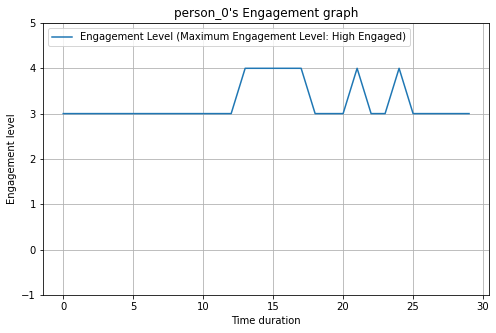

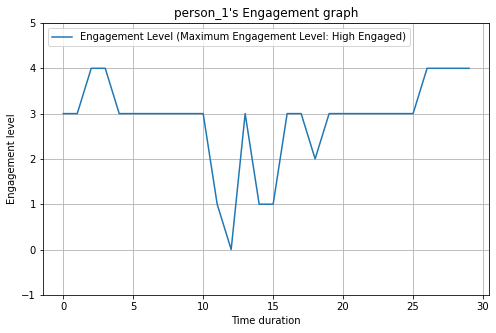

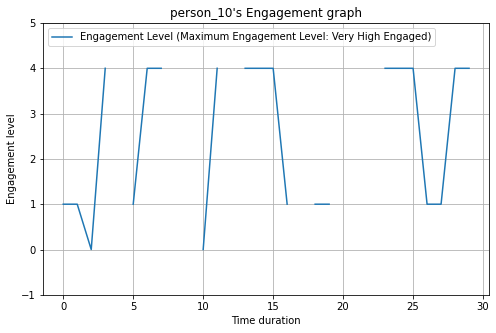

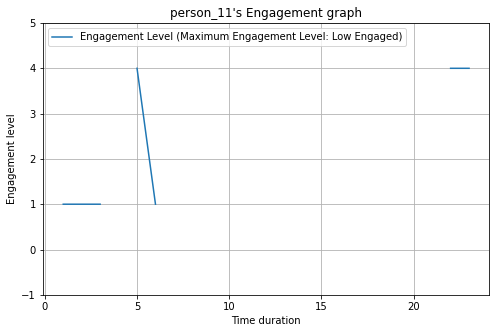

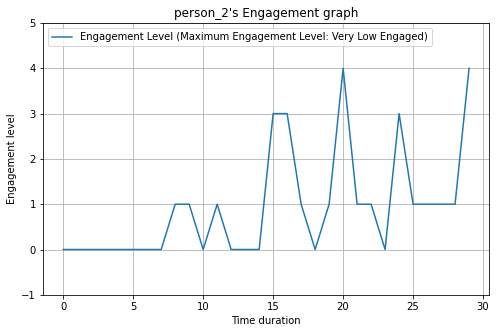

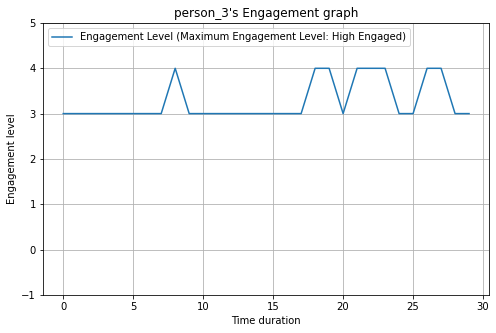

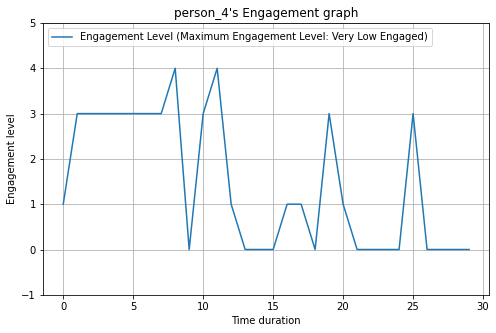

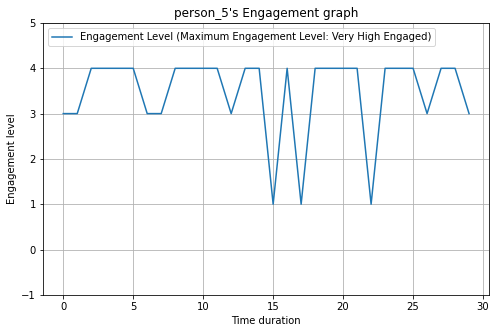

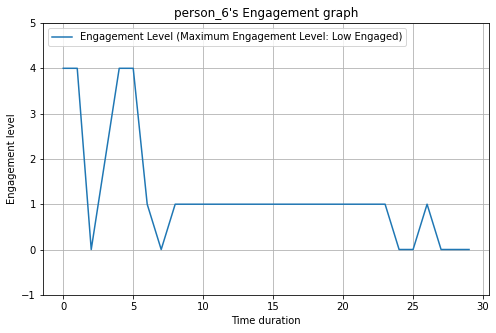

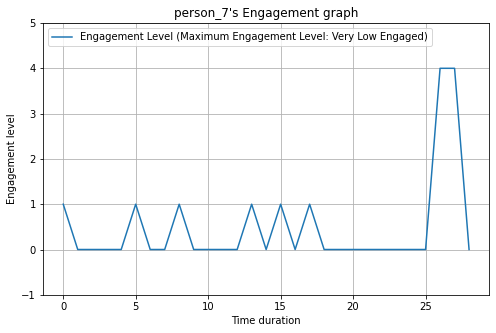

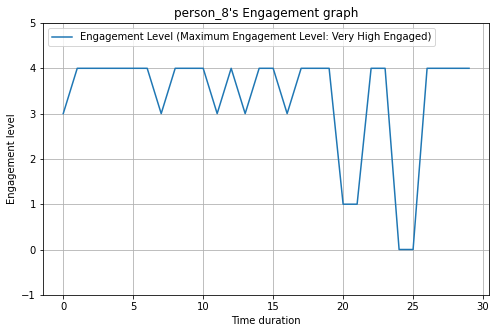

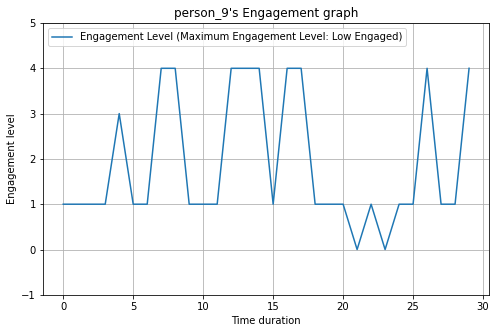

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Function to plot and save individual line graphs for all CSV files in a directory
def plot_and_save_line_graphs(directory_path, save_directory, column_name):
    # Create the save directory if it doesn't exist
    os.makedirs(save_directory, exist_ok=True)
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.csv'):
            plt.figure(figsize=(8, 5))
            csv_file = os.path.join(directory_path, filename)
            df = pd.read_csv(csv_file)
            
            # Set a fixed y-axis scale ranging from -1 to 5 with an interval of 1 unit
            plt.ylim(-1, 5)
            
            plt.plot(df[column_name], label=column_name)
            plt.xlabel('Time duration')
            plt.ylabel('Engagement level')
            plt.title(f'{filename[:-4]}\'s Engagement graph')
            plt.legend()
            plt.grid(True)
            
            # Calculate and display engagement percentage near the legend
            total_frames = len(df)
            #engagement_percentage = (df[value_column].sum() / df[value_column].count()) * 100
            max_eng_level=df[value_column].mode().iloc[0]
            eng_label='NaN'
            if max_eng_level == 4:
                eng_label='Very High Engaged'
            elif max_eng_level == 3:
                eng_label='High Engaged'
            elif max_eng_level == 2:
                eng_label='Moderate Engaged'
            elif max_eng_level == 1:
                eng_label='Low Engaged'
            elif max_eng_level == 0:
                eng_label='Very Low Engaged'   
            legend_text = f'{column_name} (Maximum Engagement Level: {eng_label})'
            plt.legend([legend_text], loc='upper left')
            
            # Save the graph to the specified directory with 300 DPI
            save_path = os.path.join(save_directory, f'Person{filename[5:-4]} \'s Engagement graph.png')
            plt.savefig(save_path, format='png', dpi=200)
            
            # Display the graph
            plt.show()

# Directory path containing CSV files
csv_directory = os.path.join('runs',output_base_path[7:],'data')

# Directory path to save the graphs
save_directory = os.path.join('runs',output_base_path[7:],'data')

# Column name to be plotted
column_to_plot = 'Engagement Level'

# Plot and save individual line graphs for the specified column in each CSV file in the directory
plot_and_save_line_graphs(csv_directory, save_directory, column_to_plot)


## Overall class group engagement percentage and graph generation

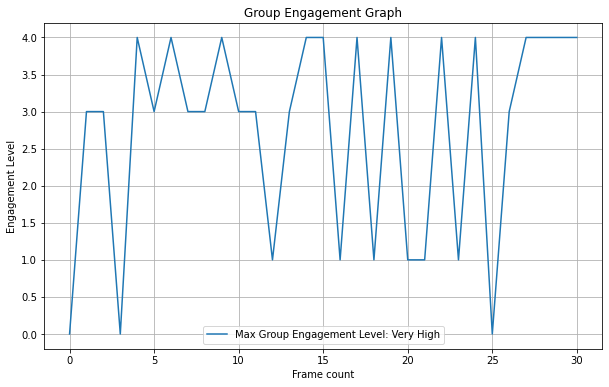

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Specify the directory containing CSV files
directory_path = os.path.join('runs',output_base_path[7:])  # Replace with the path to your directory

# Directory path to save the graphs
save_directory = os.path.join('runs',output_base_path[7:])

# Get a list of all files in the directory
all_files = os.listdir(directory_path)

# Specify the column you want to plot
column_name = 'MGEL'  # Replace with the desired column name

# Filter for CSV files
csv_files = [file for file in all_files if file.endswith('.csv')]

# Load the first CSV file found
if csv_files:
    file_path = os.path.join(directory_path, csv_files[0])
    df = pd.read_csv(file_path)

    # Specify the column you want to plot
    #column_name = 'MGEL'  # Replace with the desired column name

    # Plotting
    plt.figure(figsize=(10, 6))  # Adjust figure size if needed
    plt.plot(df[column_name])
    plt.title(f'Group Engagement Graph')
    plt.xlabel('Frame count')
    plt.ylabel('Engagement Level')
    plt.grid(True)

    engagement_max = df[column_name].mode().iloc[0]
    if engagement_max == 4:
        label="Very High"
    elif engagement_max == 3:
        label="High"
    elif engagement_max == 2:
        label="Moderate"
    elif engagement_max == 1:
        label="Low"
    else:
        label="Very Low"

    legend_text = f'Max Group Engagement Level: {label:}'#{engagement_max:}'
    plt.legend([legend_text])
            
    # Save the graph to the specified directory with 300 DPI
    save_path = os.path.join(save_directory, f'Group Engagement graph.png')
    plt.savefig(save_path, format='png', dpi=200)
            
    plt.show()
else:
    print("No CSV files found in the specified directory.")
